In [2]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
import psutil
import gc
#pd.io.parquet.get_engine('auto').__class__
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Init Plugin
Init Graph Optimizer
Init Kernel
Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.1
Scikit-Learn 0.24.2
GPU is available


Globals

In [3]:
cwd = os.getcwd()
FREQ = 256
database_path = 'Dataset/CHB-MIT/chb-mit-scalp-eeg-database-1.0.0/'
filtered_database_path = 'Dataset/CHB-MIT/Filtered-chb-mit/'
filted_db_parquet_path = "Dataset/CHB-MIT/dataframe-parquet"
external_hardisk_drive_path = os.path.dirname('/Volumes/LaCie/Database/')
edf_file_type = ".edf"
compressed_file_type = ".parquet.gzip"
file = "chb20_12.parquet.gzip"
#files = [external_hardisk_drive_path + "/Parquet_Seizure/" + f for f in os.listdir(external_hardisk_drive_path + "/Parquet_Seizure") if f.endswith(compressed_file_type)]

#test_patient = "chb07"

#files = [f for f in files if test_patient in f]


In [4]:
def remove_cols(dataframe, col_start = 0, col_end = 0):
    if col_end == 0:
        col_end = len(dataframe.columns) - 1
    
    dataframe = dataframe.iloc[: , col_start: col_end]
    return dataframe

In [5]:
cwd

'/Users/niklashjort/Desktop/Notes/Speciale/projects/DataHandling'

In [6]:
for f in os.listdir("test_data"):
    print(f)

.DS_Store
chb20_12.parquet.gzip
windows
chb20_12.csv


In [7]:
df = pd.read_csv("test_data/chb20_12.csv")

In [8]:
df['class'].value_counts()

Interictal     890112
Preictal II     24064
seizure          7424
Name: class, dtype: int64

In [9]:
sz_df = df.loc[df['class'] == "seizure"].reset_index(drop=True)

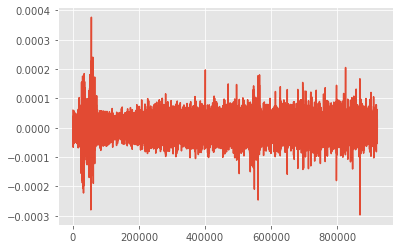

In [10]:
plt.style.use('ggplot')
plt.plot(df['FP1-F7'])

In [11]:
-2208978064003.9062

-2208978064003.9062

In [12]:
matches = ['.-0','.-1', '.-2', '.-3', '.-4', 'STI 014']

def read_compressed_df(df, channel="F3-C3"):
    
    # # Remove STI 14 col:
    # if any(x in df.columns for x in matches):
    #     for col_name in matches:
    #         try:
    #             df.drop(columns=col_name, inplace=True)
                
    #         except:
    #             pass

    df = df[['timestamp', 'class', channel]]

    sz_df = df.loc[df['class'] == "seizure"].reset_index(drop=True)
    sz_df = remove_cols(sz_df, col_end=10)

    prei_one_df = df.loc[df['class'] == "Preictal I"]
    

    prei_two_df = df.loc[df['class'] == "Preictal II"]
    prei_two_df = remove_cols(prei_two_df, col_end=10)

    inter_df = df.loc[df['class'] == "Interictal"]
    inter_df = remove_cols(inter_df, col_end=10)

    channels = [item for item in list(sz_df.columns) if item != "class" if item != "timestamp"]

    return (sz_df, prei_one_df, prei_two_df, inter_df, channels)

In [13]:
def get_window(channel, start_index, data, size = 4, overlap = 0, is_sezure = False, frequency = 256):
    if(is_sezure):
        overlap = 2
    else:
        overlap = overlap
    
    start = start_index * (size - overlap) * frequency
    end = start + (size * frequency)

    date_timestamp = ""

    try:
        date_timestamp = datetime.fromtimestamp((data['timestamp'][start:start+1]/1000).tolist()[0]).strftime('%H:%M:%S')
    except:
        date_timestamp = "datetime cannot be converted"
    
    return [data[channel][start:end].tolist(), date_timestamp]

In [14]:
def get_max_window_iteration(dataframe, buffer, overlap=0):
    len_of_df = int(len(dataframe) / (buffer*256)) + overlap
    return len_of_df


In [15]:
from scipy import signal

In [16]:
Fs = 256         # Define the sampling frequency,
interval = Fs        # ... the interval size,
overlap = Fs * 0.95  # ... and the overlap intervals

def spec_transform_save_to_folder(index, win, channel, patient_state, patient, plot_title = False):
    plt.figure(figsize=(7,7))
    series = win[0]
    time_of_observation = win[1]
    try:
        series = np.array(series).astype(np.float)
    except Exception as e:
        print(f"error: {e}")
        print(f"patient_state: {patient_state} channel: {channel} index: {index} window: {series}")
    denoised_series = denoise_wavelet(series, method='BayesShrink', mode='soft',rescale_sigma=True, multichannel=False, wavelet_levels=3)
    if plot_title:
        plt.title(f"{channel} : is_seizure = {patient_state} : {time_of_observation}")
    

    f, t, Sxx = signal.spectrogram(denoised_series, fs=Fs, nperseg=interval, noverlap=overlap)
                         
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='jet')



    #s,f,t,im = plt.specgram(denoised_series,Fs=256)
    plt.ylim(0, 20)
    #plt.axis('off')
    
    # f, t, Sxx = signal.spectrogram(denoised_series, 1./FREQ, nfft=overlap, nperseg=int(256/2))
    # #plt.pcolormesh(t, f[0:20], Sxx[0:20])
    # plt.pcolormesh(t, f, 10*np.log10(Sxx))
    plt.show()
    if patient_state == "seizure":
        plt.savefig(f'test_data//windows/Seizure2/{patient}_{index}_{channel}_{time_of_observation}.png', edgecolor='none', bbox_inches='tight')
    elif patient_state == "interictal":
        plt.savefig(f'test_data//windows/Interictal/{patient}_{index}_{channel}_{time_of_observation}.png')
    elif patient_state == "prei_one":
        plt.savefig(f'test_data//windows/test/Preictal_One/{patient}_{index}_{channel}_{str(time_of_observation).strip()}.png')
    elif patient_state == "prei_two":
        plt.savefig(f'test_data/windows/Preictal_Two/{patient}_{index}_{channel}_{str(time_of_observation).strip()}.png')
    plt.show()
    del series
    plt.clf()    
    plt.close()
    gc.collect()

In [17]:

try:
    for filename in files:
        print("started file: " + str(filename) + " index: " + str(count))
        sz, prei_one, prei_two, inter, selected_channels = read_compressed_df(filename)
        patient = re.search('/Volumes/LaCie/Database/Parquet_Seizure/(.*).parquet.gzip', filename).group(1)
        print(patient)
        for channel in selected_channels:
            if len(inter) > 0 and inter.empty == False:
                inter_win = [get_window(channel=channel,start_index=i, data=inter) for i in range(get_max_window_iteration(inter, 4))]
                for index, window in enumerate(inter_win):
                    spec_transform_save_to_folder(win=window, index=index, channel=channel, patient_state = "interictal", patient=patient)
                del inter_win

            if len(sz) > 0 and sz.empty == False:
                sz_win = [get_window(channel=channel, start_index=i, data=sz, is_sezure=True) for i in range(get_max_window_iteration(sz, 2))]
                for index, window in enumerate(sz_win):
                    spec_transform_save_to_folder(channel=channel, index=index, win=window, patient_state="seizure", patient=patient)
                del sz_win

            if len(prei_one) > 0 and prei_one.empty == False:
                prei_one_win = [get_window(channel=channel,start_index=i, data=prei_one) for i in range(get_max_window_iteration(prei_one, 4))]
                for index, window in enumerate(prei_one_win):
                    spec_transform_save_to_folder(channel=channel, index=index, win=window, patient_state="prei_one", patient=patient)
                del prei_one_win

            if len(prei_two) > 0 and prei_two.empty == False:
                prei_two_win = [get_window(channel=channel, start_index=i, data=prei_two) for i in range(get_max_window_iteration(prei_two, 4))]
                for index, window in enumerate(prei_two_win):
                    spec_transform_save_to_folder(channel=channel, index=index, win=window, patient_state="prei_two", patient=patient)
                del prei_two_win

        count += 1
        print(f"memory usage = {psutil.virtual_memory().percent} : available memory = {psutil.virtual_memory().available * 100 / psutil.virtual_memory().total}")
        print(f"filename: {filename} = done : count = {count} : files left = {len(files) - count} : time of creation = {datetime.now()}")
        del sz, prei_one, prei_two, inter
except Exception as e:
    print(e)

name 'files' is not defined


started file: chb20_12.parquet.gzip index: 0
chb20_12


/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_12669/2461979910.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='jet')


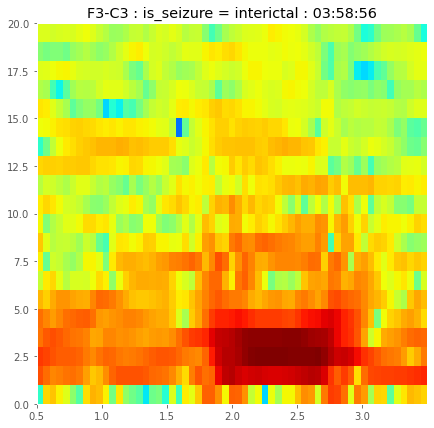

<Figure size 432x288 with 0 Axes>

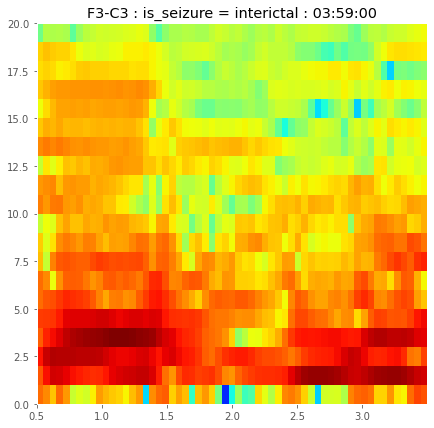

<Figure size 432x288 with 0 Axes>

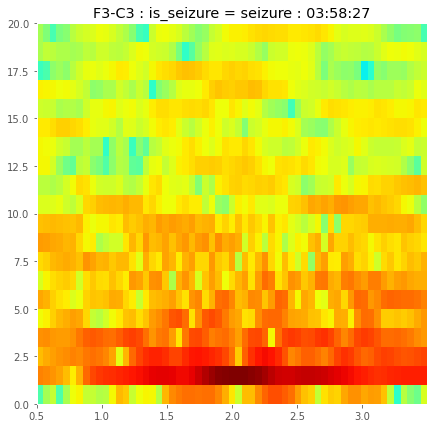

<Figure size 432x288 with 0 Axes>

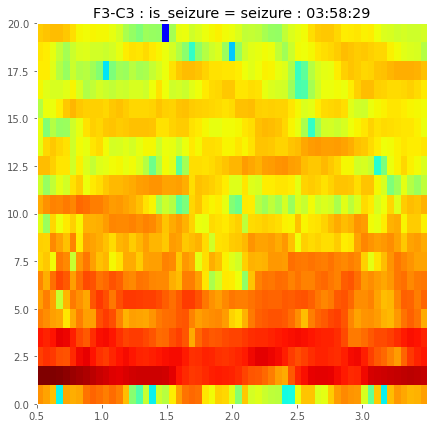

<Figure size 432x288 with 0 Axes>

In [18]:
count = 0

print("started file: " + str(file) + " index: " + str(count))
sz, prei_one, prei_two, inter, selected_channels = read_compressed_df(df)
patient = re.search('(.*).parquet.gzip', file).group(1)
print(patient)
sz_count = 0
int_count = 0
count = 0
sz_win = []
inter_win =[]
for channel in selected_channels:
    if count < 1:
        if len(inter) > 0 and inter.empty == False and int_count < 3:
            inter_win = [get_window(channel=channel,start_index=i, data=inter) for i in range(get_max_window_iteration(inter, 4))]
            for index, window in enumerate(inter_win):
                if int_count > 1:continue
                spec_transform_save_to_folder(win=window, index=index, channel=channel, patient_state = "interictal", patient=patient, plot_title=True)
                int_count += 1
            

        if len(sz) > 0 and sz.empty == False and sz_count < 3:
            sz_win = [get_window(channel=channel, start_index=i, data=sz, is_sezure=True) for i in range(get_max_window_iteration(sz, 2))]
            for index, window in enumerate(sz_win):
                if sz_count > 1:continue
                sz_count += 1
                spec_transform_save_to_folder(channel=channel, index=index, win=window, patient_state="seizure", patient=patient, plot_title=True)
            
        count += 1


del sz, prei_one, prei_two, inter


In [19]:
sz = sz_win[10][0]
inte = inter_win[25][0]

In [20]:
len(int)

TypeError: object of type 'type' has no len()

In [ ]:
time = np.arange(len(int))/256

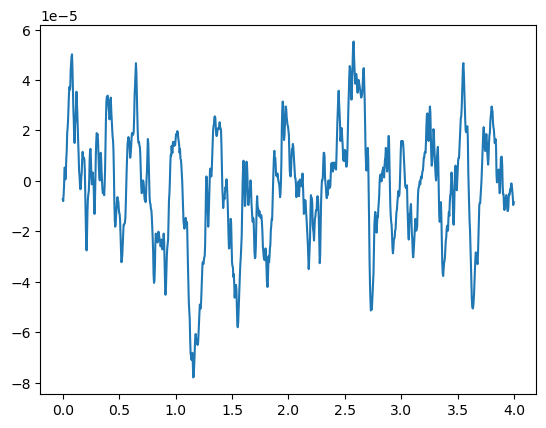

In [ ]:
plt.plot(time, int, lw=1.5)

In [ ]:
win = 4 * 256
freqs, psd = signal.welch(int, 256, nperseg=win)

In [ ]:
import mne
from mne import io
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, compute_source_psd

fmin, fmax = 4, 100 

label ="som"

stc = compute_source_psd(sz, lambda2=1. / 9., method="dSPM",
                         fmin=fmin, fmax=fmax,
                         pick_ori="normal", n_fft=1024, label=label)

TypeError: compute_source_psd() missing 1 required positional argument: 'inverse_operator'

In [ ]:
import seaborn as sns
# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

NameError: name 'freqs' is not defined

<Figure size 576x288 with 0 Axes>

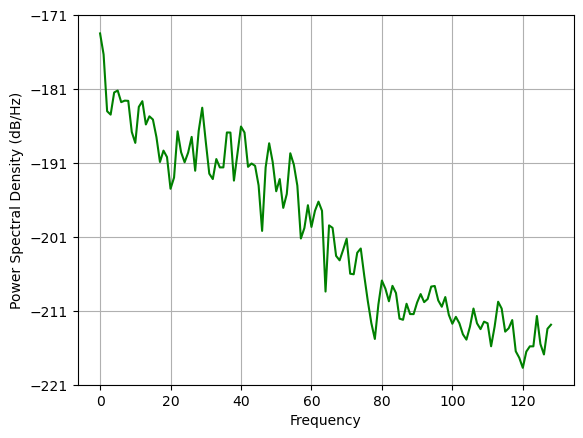

In [ ]:
plt.style.use('default')
plt.psd(np.array(sz)**2, Fs=256, color ="green")
lines = plt.gca().get_lines()
x_data = lines[0].get_data()[1]

In [ ]:
import scipy
scipy.__version__

'1.7.1'

In [ ]:
freqs = 1./256

In [ ]:
freq, psd= signal.welch(sz, fs=freqs, scaling='spectrum', window='hanning', nperseg=256, noverlap=freqs/2)

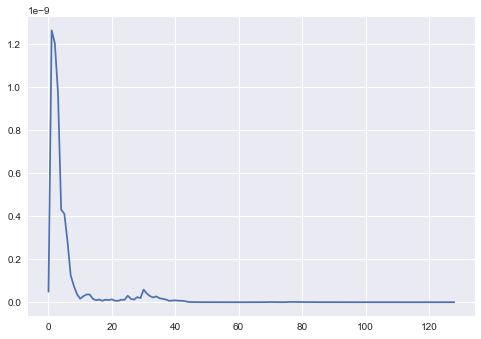

In [ ]:
plt.plot(psd)

In [ ]:
x = [10 * np.log(x) for x in psd]

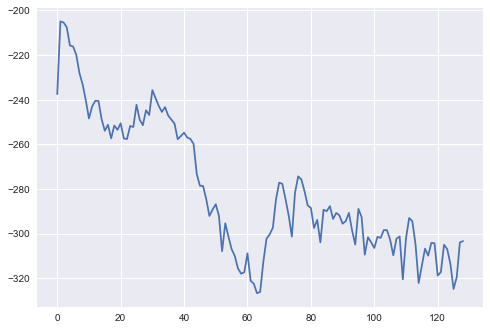

In [ ]:
plt.plot(x)

In [ ]:
plt.plot(denoise_wavelet(np.array(int).astype(np.float),wavelet='db8', method='BayesShrink', mode='hard',rescale_sigma=True, multichannel=False, wavelet_levels=3))

TypeError: float() argument must be a string or a number, not 'type'

In [ ]:
denoise_int = denoise_wavelet(np.array(int).astype(np.float),wavelet='db8', method='BayesShrink', mode='hard',rescale_sigma=True, multichannel=False, wavelet_levels=3)

TypeError: float() argument must be a string or a number, not 'type'

In [ ]:
freqs, psd1 = signal.periodogram(denoise_int, fs=1./256)

NameError: name 'denoise_int' is not defined

In [ ]:
plt.plot(psd1)

NameError: name 'psd1' is not defined

(array([[4.90707871e+03, 4.96178105e+03, 6.45830154e+03, 7.59965604e+03,
         6.72083372e+03, 7.17848286e+03, 7.56270900e+03],
        [2.80858760e+03, 2.61335082e+03, 3.58561661e+03, 4.40248888e+03,
         3.66445935e+03, 3.95080382e+03, 4.13110341e+03],
        [4.49284771e+00, 4.72555865e-02, 6.16816913e+00, 2.04647760e+01,
         2.79214915e+00, 3.11444541e+00, 1.49191330e+00],
        [5.54183841e-01, 7.76085553e-01, 2.44894552e-01, 9.58301023e-01,
         1.80381507e+00, 4.72218946e-01, 1.28369269e+00],
        [3.89014462e-01, 9.31120710e-03, 3.84850180e-01, 1.32647577e+00,
         2.12255350e+00, 6.85443091e-02, 7.47905727e-01],
        [4.30700613e-01, 1.93244667e-01, 2.72361583e-01, 9.51708406e-02,
         6.43983908e-01, 2.86503903e-01, 2.21028166e+00],
        [3.49173565e-01, 3.65788784e-01, 5.24015859e-02, 1.22132849e+00,
         4.60169204e-01, 8.29800321e-02, 1.29593188e+00],
        [3.63888709e-02, 8.18388216e-02, 1.40231611e-01, 2.46200058e-01,
         5

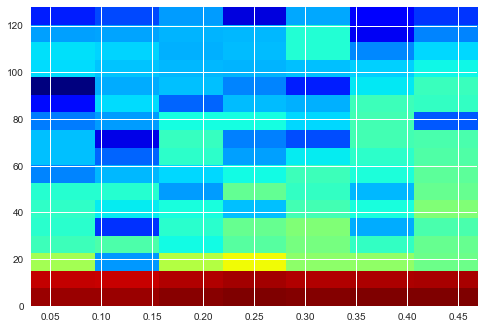

In [ ]:
plt.specgram(x, Fs=256,cmap='jet', NFFT=32, noverlap=16)

/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_7743/2069856126.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(times, frequencies, 10*np.log10(spectrogram))


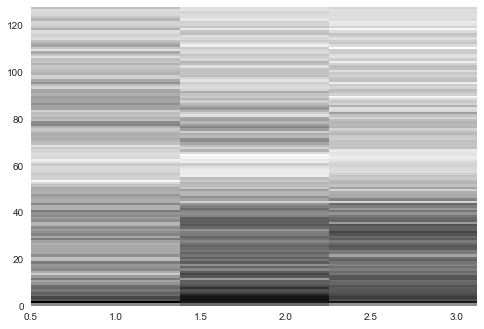

In [ ]:
frequencies, times, spectrogram = signal.spectrogram(np.array(sz), 256)
plt.pcolormesh(times, frequencies, 10*np.log10(spectrogram))


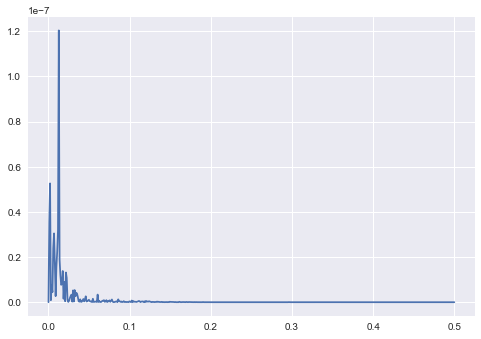

In [ ]:
freqs, psd2 = signal.periodogram(inte)
plt.axis('on')
plt.plot(freqs, psd2)


In [ ]:
import matplotlib

In [ ]:
plt.specgram(psd2.transpose(), NFFT=16,Fs=256,cmap='jet', noverlap=8)
plt.show()

NameError: name 'psd2' is not defined

In [ ]:
sz = denoise_wavelet(np.array(sz).astype(np.float),wavelet='db8', method='BayesShrink', mode='hard',rescale_sigma=True, multichannel=False, wavelet_levels=3)

In [ ]:
ps1 = np.abs(np.fft.fft(sz))**2

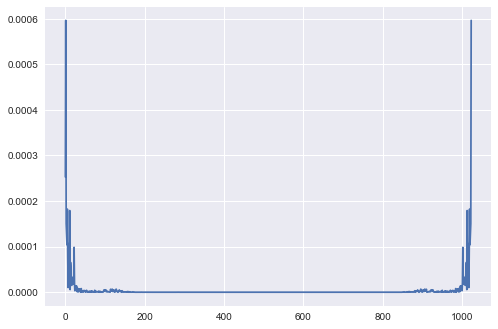

In [ ]:
plt.plot(ps1)

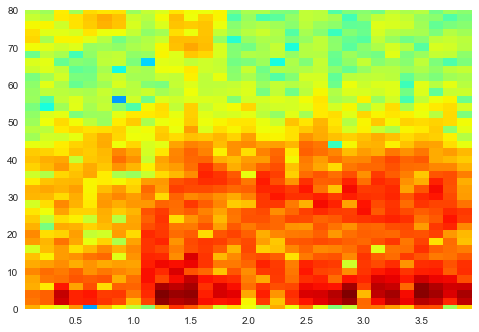

In [ ]:
frequencies, times, spectrogram = signal.spectrogram(sz, fs=256, nfft=256/2, noverlap=256/8, nperseg=64)
plt.ylim(0, 80)
plt.pcolormesh(times, frequencies, 10*np.log10(spectrogram), shading='auto', cmap=plt.get_cmap('jet'))

In [ ]:
frequencies

array([ 0.     ,  0.78125,  1.5625 ,  2.34375,  3.125  ,  3.90625,
        4.6875 ,  5.46875,  6.25   ,  7.03125,  7.8125 ,  8.59375,
        9.375  , 10.15625, 10.9375 , 11.71875, 12.5    , 13.28125,
       14.0625 , 14.84375, 15.625  , 16.40625, 17.1875 , 17.96875,
       18.75   , 19.53125, 20.3125 , 21.09375, 21.875  , 22.65625,
       23.4375 , 24.21875, 25.     ])

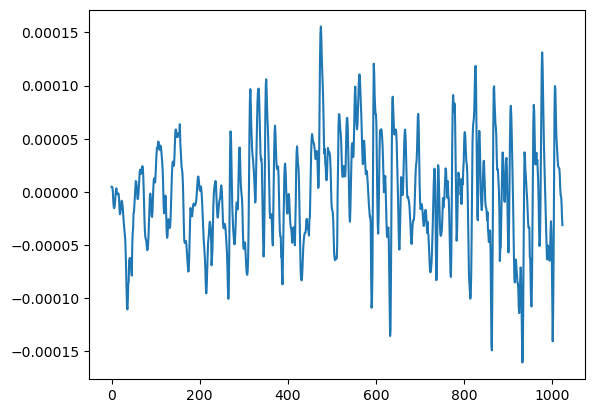

In [ ]:
plt.plot(sz)

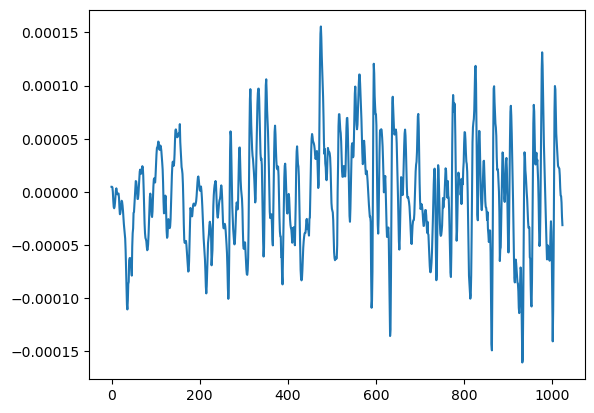

In [ ]:
plt.plot(denoise_wavelet(np.array(sz, dtype=np.float32), wavelet='db8', method='BayesShrink', mode='soft',rescale_sigma=True, multichannel=False, wavelet_levels=4))

In [ ]:
from scipy import signal

In [ ]:
freqs, psd = signal.welch(inte, 256, scaling='density')

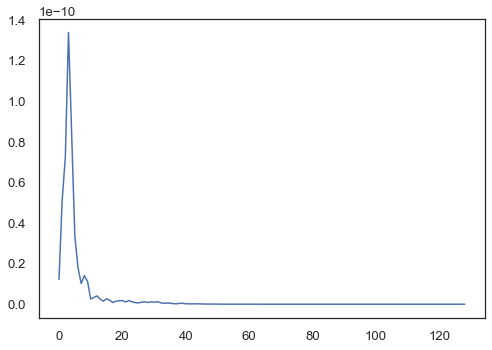

In [ ]:
plt.plot(freqs, psd)

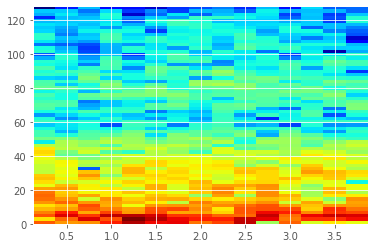

In [40]:
s,f,t,im = plt.specgram(inte,Fs=256,cmap='jet', NFFT=128, noverlap=64)

plt.show()

In [ ]:
from scipy.fft import fft

fft(sz)

array([-0.00191348-0.j        , -0.00728911+0.00167341j,
        0.00367577-0.00114821j, ..., -0.00352396+0.00040299j,
        0.00367577+0.00114821j, -0.00728911-0.00167341j])

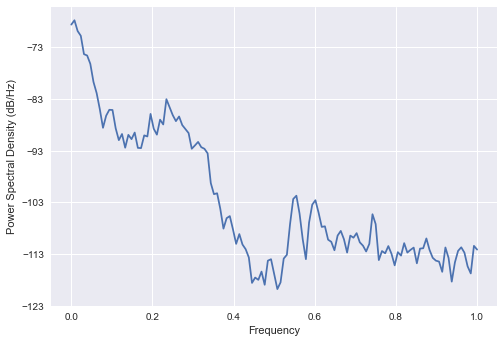

In [ ]:
x = plt.psd(sz)

ax = plt.gca()
line = ax.lines[0]
b = line.get_xydata()

In [21]:
chosen = np.array(inter_win[80][0])

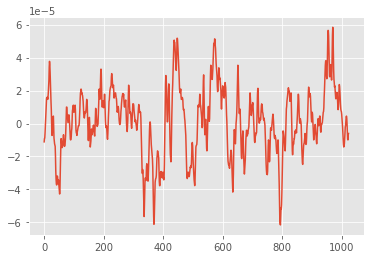

In [ ]:
plt.plot(chosen)

In [42]:
Fs = 256         # Define the sampling frequency,
interval = Fs        # ... the interval size,
overlap = Fs * 0.99  # ... and the overlap intervals

/var/folders/0v/m6wt8rqj7s1dcljdyjrdfxmw0000gn/T/ipykernel_12669/286692102.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t, f, 10 * np.log10(Sxx),


(0.0, 10.0)

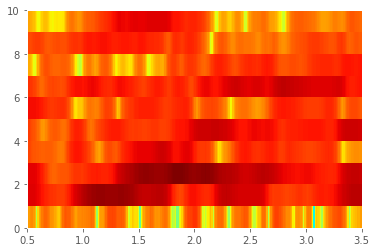

In [43]:
#plt.ylim(0, 10)
f, t, Sxx = signal.spectrogram(
    chosen,                  # Provide the signal,
    fs=Fs,                # ... the sampling frequency,
    nperseg=interval,     # ... the length of a segment,
    noverlap=overlap)
                          # ... the number of samples to overlap,
plt.pcolormesh(t, f, 10 * np.log10(Sxx),
            cmap='jet')# Plot the result

plt.ylim(0,10)

(array([[2.12240774e-12, 3.33217310e-11, 6.24061034e-11, 1.27220325e-11,
         3.38195205e-12, 3.43089307e-11, 1.65220948e-11],
        [1.99555686e-11, 8.31433003e-11, 2.78278846e-10, 4.63561643e-11,
         5.16456112e-11, 6.17993944e-11, 4.71732579e-11],
        [1.36410493e-11, 7.26896004e-12, 2.19700354e-10, 2.19668552e-10,
         7.99157221e-11, 5.49207368e-11, 3.23454140e-11],
        [1.05610728e-11, 4.05399449e-12, 2.16820269e-11, 4.93986757e-11,
         3.61845849e-11, 1.50796597e-11, 8.67973057e-12],
        [1.07124358e-11, 6.32264733e-12, 1.11808892e-11, 7.25267569e-11,
         4.42024231e-11, 2.49967990e-11, 4.02378975e-11],
        [1.88904977e-11, 1.91668665e-12, 1.41966330e-11, 2.03001262e-11,
         3.56030670e-11, 5.00609384e-11, 1.07298087e-11],
        [9.31308851e-13, 2.16102325e-11, 2.26213726e-11, 1.63776547e-11,
         6.64846823e-11, 7.26674190e-11, 1.25831446e-11],
        [3.03640702e-13, 4.70520711e-12, 3.69158011e-13, 7.04021004e-12,
         3

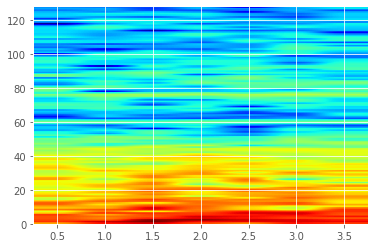

In [32]:

plt.specgram(chosen, Fs=256, cmap='jet')
#plt.ylim(0,10)